Utilizamos la electricidad en función de las distintas actividades en las que la necesitamos, por ejemplo, el hogar, el alumbrado público, la industria, el comercio o el ocio; cada una de estas actividades tiene su propio patrón de uso y comportamiento.

La variación del comportamiento de la demanda de energía depende de varios factores, algunos de los cuales son el encendido y apagado de los aparatos eléctricos, los periodos vacacionales, los días de descansos entre otros factores.


**Balance de energía**

Barcelona consume 13.222 GWh/año y, de estos, solo cerca de 1.229 GWh se producen con energías renovables. Para reducir el consumo global de 7,95 MWh de media por habitante, el Ayuntamiento quiere minimizar la dependencia energética de la ciudad de los combustibles fósiles, fomentar la generación local de energía renovable para reducir las emisiones de CO2 y diseñar un nuevo modelo energético más sostenible. Debemos tener en cuenta que en el 2020 se bajó desde los 15.320 GWh/año del 2019, a causa de la pandemia de COVID-19, y que estos descensos no están consolidados.

Actualmente, la ciudad genera localmente 4.373 GWh/año de electricidad, una cantidad que representa en torno al 76 % de la energía eléctrica que se consume en Barcelona. Pero de esta energía solo un 1 % es renovable, por lo que el reto es doble: generar más energía local y que sea limpia. Datos del  [Observatorio de la Energía](https://www.energia.barcelona/es/el-observatorio-de-la-energia-0).

# Librerias

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import (SQLContext, HiveContext)
from pyspark.sql.types import *
from pyspark.sql.functions import sin,cos
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
import urllib
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import holidays
import numpy as np
import math

# Funciones

In [2]:
#función (1) que define si el día es fin de semana o no 
def type_day(date):
    business_day = bool(len(pd.bdate_range(date, date)))
    if business_day == True:
        business_day = 1
    else:
        business_day = 0
    return business_day  

In [3]:
#función (2) definir si el día es laborable o no, 1 = Holiday, 0 = Normal  
def cat_hol(date):
    cat_hol = holidays.country_holidays('Spain', subdiv='CT')
    h = date in cat_hol
    if h == True:
        h = 1
    else:
        h = 0
    return h

In [4]:
#función (3) indexado de vriables categoricas
def string_indexer(col_in,col_out):
    return StringIndexer(inputCol= col_in,outputCol= col_out)

In [5]:
#función (4) oneHotEncoding de las variables categoricas
def string_encoder(col_in,col_out):
    return OneHotEncoder(inputCol=col_in,outputCol=col_out)

# Cargar datos

In [6]:
#cargar datos de la pagina de OpenData Barcelona
url = "https://opendata-ajuntament.barcelona.cat/data/dataset/\
d9479057-781f-42b4-85e6-721bd0284130/resource/2b6ef2c2-cbd0-437c-a229-889e992e1dd6/\
download/2021_consum_electricitat_bcn.csv2021_consum_electricitat_bcn.csv"

file_name, headers = urllib.request.urlretrieve(url)

In [7]:
#iniciar sesion
sc = pyspark.SparkContext(master="local[1]",appName="PF_Francisco_Regalado")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/22 00:07:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
#cargar el archivo
sqlContext = SQLContext(sc)

energy_consumption = sqlContext.read.format("csv").options(delimiter=',',header='True',inferschema='True')\
                .load(file_name)

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [9]:
energy_consumption.show()

+----+-------------------+-----------+---------------+--------------------+-----+
| Any|               Data|Codi_Postal|Sector_Economic|         Tram_Horari|Valor|
+----+-------------------+-----------+---------------+--------------------+-----+
|2021|2021-01-01 00:00:00|       8001|      Indústria|De 00:00:00 a 05:...|  692|
|2021|2021-01-01 00:00:00|       8001|      Indústria|De 06:00:00 a 11:...|  790|
|2021|2021-01-01 00:00:00|       8001|      Indústria|De 12:00:00 a 17:...| 1178|
|2021|2021-01-01 00:00:00|       8001|      Indústria|De 18:00:00 a 23:...|  905|
|2021|2021-01-01 00:00:00|       8001|      Indústria|           No consta|    0|
|2021|2021-01-01 00:00:00|       8001|    Residencial|De 00:00:00 a 05:...|30570|
|2021|2021-01-01 00:00:00|       8001|    Residencial|De 06:00:00 a 11:...|30529|
|2021|2021-01-01 00:00:00|       8001|    Residencial|De 12:00:00 a 17:...|50741|
|2021|2021-01-01 00:00:00|       8001|    Residencial|De 18:00:00 a 23:...|52035|
|2021|2021-01-01

In [10]:
energy_consumption.dtypes

[('Any', 'int'),
 ('Data', 'timestamp'),
 ('Codi_Postal', 'int'),
 ('Sector_Economic', 'string'),
 ('Tram_Horari', 'string'),
 ('Valor', 'int')]

In [11]:
#me interesa que el Codi_Postal sea un string, así que se cambiará
customSchema = StructType([ \
    StructField("Any", IntegerType(), True), \
    StructField("Data", DateType(), True), \
    StructField("Codi_Postal", StringType(), True), \
    StructField("Sector_Economic", StringType(), True), \
    StructField("Tram_Horari", StringType(), True), \
    StructField("Valor", IntegerType(), True)])

In [12]:
#se vuelven a cargar los datos
energy_consumption = sqlContext.read.format("csv").options(delimiter=',',header='True')\
                  .schema(schema = customSchema).load(file_name)

In [13]:
energy_consumption.show()

+----+----------+-----------+---------------+--------------------+-----+
| Any|      Data|Codi_Postal|Sector_Economic|         Tram_Horari|Valor|
+----+----------+-----------+---------------+--------------------+-----+
|2021|2021-01-01|      08001|      Indústria|De 00:00:00 a 05:...|  692|
|2021|2021-01-01|      08001|      Indústria|De 06:00:00 a 11:...|  790|
|2021|2021-01-01|      08001|      Indústria|De 12:00:00 a 17:...| 1178|
|2021|2021-01-01|      08001|      Indústria|De 18:00:00 a 23:...|  905|
|2021|2021-01-01|      08001|      Indústria|           No consta|    0|
|2021|2021-01-01|      08001|    Residencial|De 00:00:00 a 05:...|30570|
|2021|2021-01-01|      08001|    Residencial|De 06:00:00 a 11:...|30529|
|2021|2021-01-01|      08001|    Residencial|De 12:00:00 a 17:...|50741|
|2021|2021-01-01|      08001|    Residencial|De 18:00:00 a 23:...|52035|
|2021|2021-01-01|      08001|    Residencial|           No consta|    0|
|2021|2021-01-01|      08001|        Serveis|De 00:

In [14]:
energy_consumption.printSchema()

root
 |-- Any: integer (nullable = true)
 |-- Data: date (nullable = true)
 |-- Codi_Postal: string (nullable = true)
 |-- Sector_Economic: string (nullable = true)
 |-- Tram_Horari: string (nullable = true)
 |-- Valor: integer (nullable = true)



# Análisis Explotoratorio de Datos

In [15]:
energy_consumption.describe().show()

+-------+------+------------------+---------------+--------------------+------------------+
|summary|   Any|       Codi_Postal|Sector_Economic|         Tram_Horari|             Valor|
+-------+------+------------------+---------------+--------------------+------------------+
|  count|243645|            243645|         243645|              243645|            243645|
|   mean|2021.0| 8021.119005109894|           null|                null| 25413.80446551335|
| stddev|   0.0|12.033369578537195|           null|                null|30921.412598267172|
|    min|  2021|             08001|      Indústria|De 00:00:00 a 05:...|                 0|
|    max|  2021|             08042|        Serveis|           No consta|            260278|
+-------+------+------------------+---------------+--------------------+------------------+



In [16]:
#registrar la tabla
sqlContext.sql("drop TABLE IF EXISTS energy_consumption")
sqlContext.registerDataFrameAsTable(energy_consumption, "energy_consumption")

## Consumo por Sector Económico 

In [17]:
#me interesa conocer el consumo por sector economico 
Sector_Economic = sqlContext.sql(""" SELECT Sector_Economic,SUM(Valor) 
                   FROM energy_consumption 
                   Group By Sector_Economic
                      """)
Sector_Economic.show()

+---------------+----------+
|Sector_Economic|sum(Valor)|
+---------------+----------+
| No especificat|   3140421|
|        Serveis|3386646681|
|    Residencial|2216839702|
|      Indústria| 585319585|
+---------------+----------+



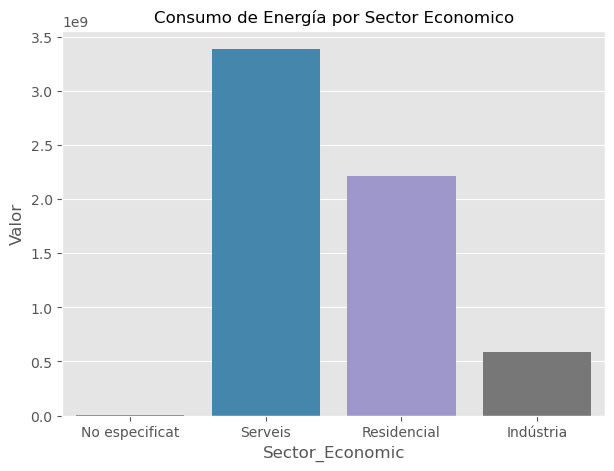

In [18]:
Sector_Economic_data = Sector_Economic.collect()

Sector_Economic_df = pd.DataFrame(Sector_Economic_data,columns=["Sector_Economic","Valor"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Sector Economico",fontsize=12)
sns.barplot(data=Sector_Economic_df, x="Sector_Economic", y="Valor")
plt.show()

La gráfica superior nos dice que el sector servicios es el que consume más energia en la ciudad de barcelona, existe un sector no espeficado pero los datos son menores.

## Consumo por tramo horario

In [19]:
Tram_Horari = sqlContext.sql(""" SELECT Tram_Horari,SUM(Valor) 
                   FROM energy_consumption 
                   GROUP BY Tram_Horari
                   ORDER BY Tram_Horari
                      """)
Tram_Horari.show()

+--------------------+----------+
|         Tram_Horari|sum(Valor)|
+--------------------+----------+
|De 00:00:00 a 05:...|1092114209|
|De 06:00:00 a 11:...|1587363445|
|De 12:00:00 a 17:...|1830926172|
|De 18:00:00 a 23:...|1681202782|
|           No consta|    339781|
+--------------------+----------+



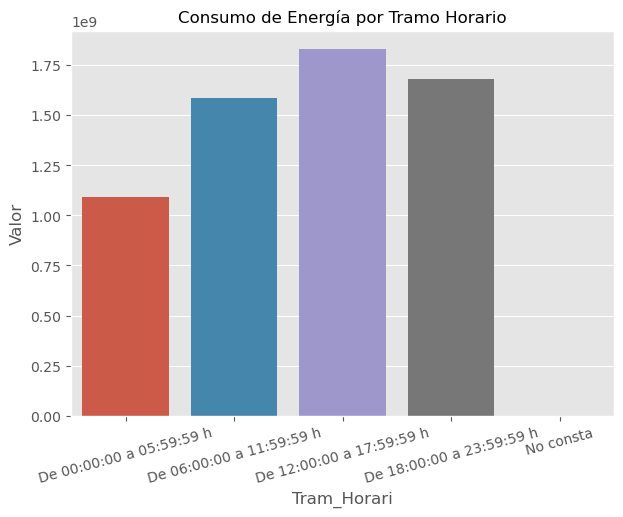

In [20]:
Tram_Horari_data = Tram_Horari.collect()

Tram_Horari_df = pd.DataFrame(Tram_Horari_data,columns=["Tram_Horari","Valor"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Tramo Horario",fontsize=12)
sns.barplot(data=Tram_Horari_df, x="Tram_Horari", y="Valor")
plt.xticks(rotation=15)
plt.show()

La gráfica superior nos dice que el tramo horario de mayor consumo es el de las 12-6pm pero en general el consumo de energia es "similar" si tiene un descenso notable durante la madrugada.

In [21]:
#quiero saber cual es el consumo mínimo
min_valor_tramHorari = sqlContext.sql(""" SELECT Tram_Horari, MIN(Valor) 
                   FROM energy_consumption 
                   GROUP BY Tram_Horari
                   ORDER BY Tram_Horari
                      """)
min_valor_tramHorari.show()

+--------------------+----------+
|         Tram_Horari|min(Valor)|
+--------------------+----------+
|De 00:00:00 a 05:...|        22|
|De 06:00:00 a 11:...|        28|
|De 12:00:00 a 17:...|        28|
|De 18:00:00 a 23:...|        24|
|           No consta|         0|
+--------------------+----------+



Los mínimos de consumo de energía por tramo horario son similares, <br> 
existen valores cero que no y no se especifica el tramo horario.

In [22]:
#consumo máximo
max_valor_tramHorari = sqlContext.sql(""" SELECT Tram_Horari, MAX(Valor) 
                   FROM energy_consumption 
                   GROUP BY Tram_Horari
                   ORDER BY Tram_Horari
                      """)
max_valor_tramHorari.show()

+--------------------+----------+
|         Tram_Horari|max(Valor)|
+--------------------+----------+
|De 00:00:00 a 05:...|    170255|
|De 06:00:00 a 11:...|    207541|
|De 12:00:00 a 17:...|    231868|
|De 18:00:00 a 23:...|    260278|
|           No consta|     18740|
+--------------------+----------+



Los valores máximos van en aumento según el tramo horario,los valores sin tramo horario  <br>especificado son notables.

## Consumo por fecha

In [23]:
data = sqlContext.sql(""" SELECT Data, SUM(Valor) 
                   FROM energy_consumption 
                   GROUP BY Data
                   ORDER BY Data
                      """)
data.show()

+----------+----------+
|      Data|sum(Valor)|
+----------+----------+
|2021-01-01|  15137300|
|2021-01-02|  16270607|
|2021-01-03|  16204520|
|2021-01-04|  20010496|
|2021-01-05|  20189739|
|2021-01-06|  16993046|
|2021-01-07|  21401418|
|2021-01-08|  21520295|
|2021-01-09|  18795676|
|2021-01-10|  17801954|
|2021-01-11|  21817167|
|2021-01-12|  22293188|
|2021-01-13|  21808821|
|2021-01-14|  21457161|
|2021-01-15|  20851284|
|2021-01-16|  17451015|
|2021-01-17|  16062187|
|2021-01-18|  20112424|
|2021-01-19|  19787940|
|2021-01-20|  19630460|
+----------+----------+
only showing top 20 rows



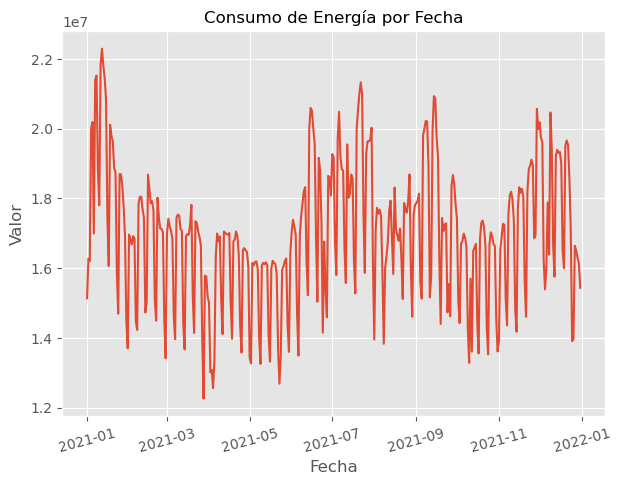

In [24]:
data_data = data.collect()

data_df = pd.DataFrame(data_data,columns=["Fecha","Valor"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.lineplot(data=data_df, x="Fecha", y="Valor")
plt.xticks(rotation=15)
plt.show()

Existe un mayor consumo de energia durante el invierno y el verano.

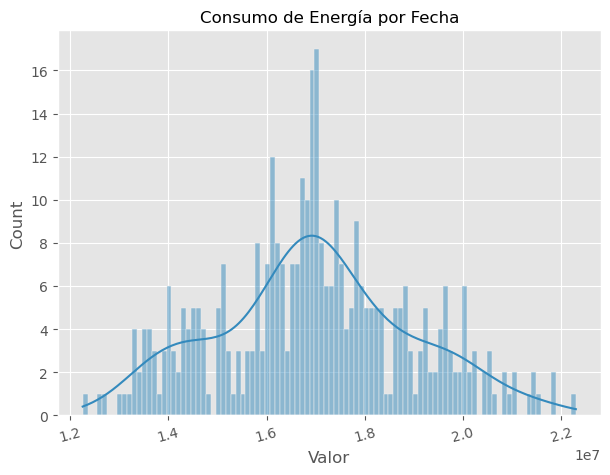

In [35]:

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.histplot(data=data_df, x="Valor", kde=True, bins=100)
plt.xticks(rotation=15)
plt.show()

La dispersión de los valores durante toda la serie temporal teniendo una skew asimetrica positiva.

In [138]:
data_outlier_day = sqlContext.sql(""" SELECT Data, Valor 
                   FROM energy_consumption
                   WHERE Valor < 10
                   GROUP BY Data,Valor
                   ORDER BY Data
                      """)
data_outlier_day.show(5)

+----------+-----+
|      Data|Valor|
+----------+-----+
|2021-01-01|    7|
|2021-01-01|    0|
|2021-01-01|    2|
|2021-01-02|    0|
|2021-01-02|    2|
+----------+-----+
only showing top 5 rows



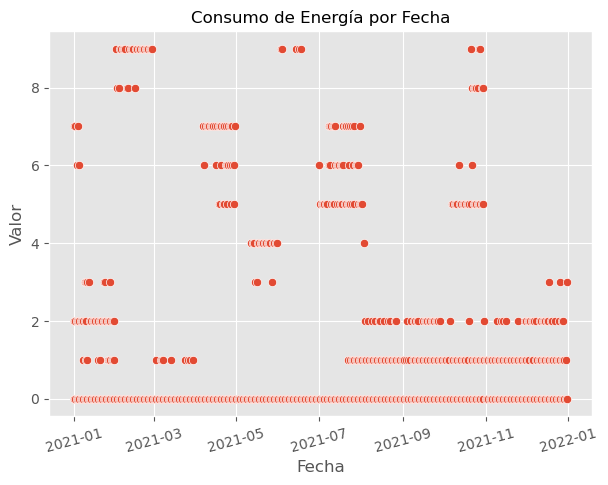

In [143]:
data_outlier_day_data = data_outlier_day.collect()

data_outlier_day_df = pd.DataFrame(data_outlier_day_data,columns=["Fecha","Valor"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.scatterplot(data=data_outlier_day_df,x="Fecha",y="Valor")
plt.xticks(rotation=15)
plt.show()

Existe al menos un valor cero por día durante toda la serie temporal y los minimos se encuentran concentrados en algunas fechas.

In [25]:
meses_consumo = sqlContext.sql(""" SELECT MONTH(Data) as Month, SUM(Valor) 
                   FROM energy_consumption 
                   GROUP BY Month
                   ORDER BY Month
                      """)
meses_consumo.show()

+-----+----------+
|Month|sum(Valor)|
+-----+----------+
|    1| 572435059|
|    2| 466427384|
|    3| 502361837|
|    4| 471229921|
|    5| 471616480|
|    6| 521048705|
|    7| 576277543|
|    8| 521810181|
|    9| 533377501|
|   10| 490789520|
|   11| 518734770|
|   12| 545837488|
+-----+----------+



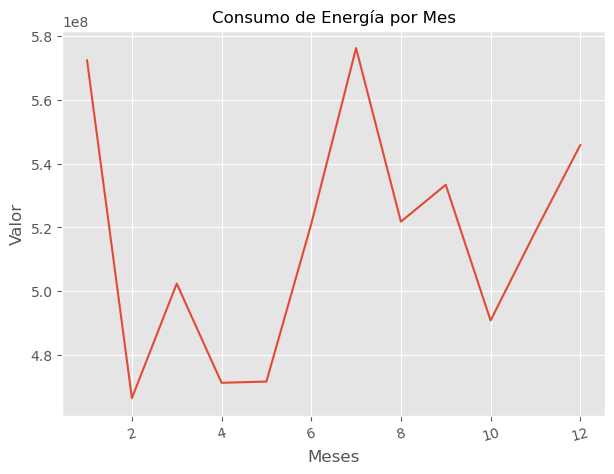

In [26]:
meses_consumo_data = meses_consumo.collect()

meses_consumo_df = pd.DataFrame(meses_consumo_data,columns=["Meses","Valor"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Mes",fontsize=12)
sns.lineplot(data=meses_consumo_df, x="Meses", y="Valor")
plt.xticks(rotation=15)
plt.show()

El mayor consumo se produce en Julio seguido de Enero.

In [29]:
meses_consumo_disperso = sqlContext.sql(""" SELECT MONTH(Data) as Month, Valor
                   FROM energy_consumption 
                   GROUP BY Month,Valor
                   ORDER BY Month
                      """)
meses_consumo_disperso.show()

+-----+------+
|Month| Valor|
+-----+------+
|    1| 48350|
|    1| 55182|
|    1|   587|
|    1| 62089|
|    1| 38294|
|    1|101612|
|    1|   869|
|    1| 32024|
|    1| 56205|
|    1|  1720|
|    1| 39279|
|    1|111311|
|    1|  1348|
|    1| 56383|
|    1| 11410|
|    1|  2667|
|    1|106479|
|    1| 33507|
|    1| 54317|
|    1| 63253|
+-----+------+
only showing top 20 rows



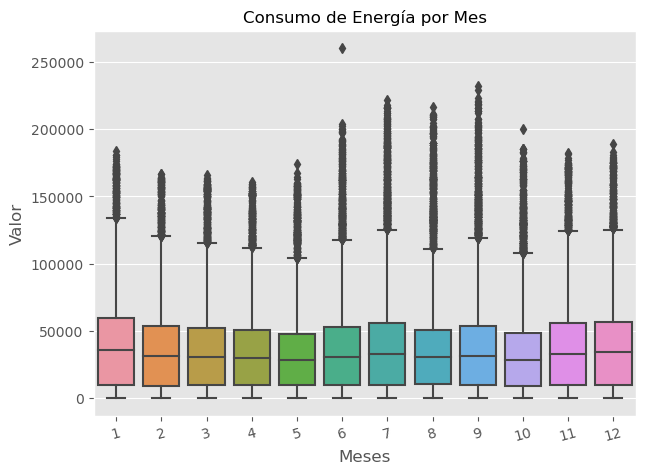

In [32]:
meses_consumo_disperso_data = meses_consumo_disperso.collect()

meses_consumo_disperso_df = pd.DataFrame(meses_consumo_disperso_data,columns=["Meses","Valor"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Mes",fontsize=12)
sns.boxplot(data=meses_consumo_disperso_df, x="Meses", y="Valor")
plt.xticks(rotation=15)
plt.show()

In [36]:
dia_consumo_disperso = sqlContext.sql(""" SELECT DAY(Data) as Day, Valor
                   FROM energy_consumption 
                   GROUP BY Day,Valor
                   ORDER BY Day
                      """)
dia_consumo_disperso.show()

+---+-----+
|Day|Valor|
+---+-----+
|  1|17600|
|  1|52576|
|  1|56383|
|  1|55182|
|  1|62089|
|  1|63352|
|  1|38294|
|  1|15324|
|  1| 4367|
|  1|43351|
|  1|56205|
|  1| 2667|
|  1|35501|
|  1|21724|
|  1| 3452|
|  1|55038|
|  1|47703|
|  1|77593|
|  1| 2483|
|  1| 2324|
+---+-----+
only showing top 20 rows



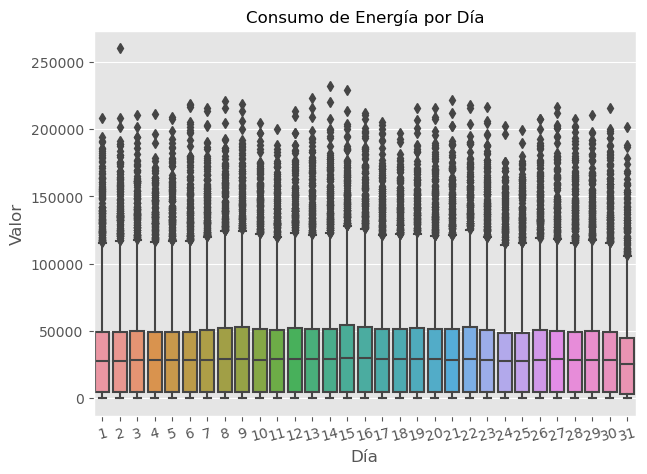

In [37]:
dia_consumo_disperso_data = dia_consumo_disperso.collect()

dia_consumo_disperso_df = pd.DataFrame(dia_consumo_disperso_data,columns=["Día","Valor"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Día",fontsize=12)
sns.boxplot(data= dia_consumo_disperso_df, x= "Día", y= "Valor")
plt.xticks(rotation=15)
plt.show()

Con las gráficas anteriores se observa una gran grantidad de datos outliers. 

# Obtener la tabla final

In [495]:
#voy a separar las fechas por mes y día
final_data_table = sqlContext.sql(""" SELECT Data, MONTH(Data) AS Month,DAY(Data) AS Day,Codi_Postal,
                   Tram_Horari,Sector_Economic, SUM(Valor) as Valor
                   FROM energy_consumption 
                   WHERE Tram_Horari != "No consta" AND Valor >=1
                   Group By Data,Codi_Postal,Tram_Horari,Sector_Economic
                   ORDER BY Data
                      """)
final_data_table.show()

+----------+-----+---+-----------+--------------------+---------------+------+
|      Data|Month|Day|Codi_Postal|         Tram_Horari|Sector_Economic| Valor|
+----------+-----+---+-----------+--------------------+---------------+------+
|2021-01-01|    1|  1|      08005|De 12:00:00 a 17:...|        Serveis| 56494|
|2021-01-01|    1|  1|      08037|De 18:00:00 a 23:...|      Indústria|   669|
|2021-01-01|    1|  1|      08017|De 12:00:00 a 17:...| No especificat|   100|
|2021-01-01|    1|  1|      08041|De 06:00:00 a 11:...|    Residencial| 38620|
|2021-01-01|    1|  1|      08026|De 00:00:00 a 05:...|    Residencial| 27602|
|2021-01-01|    1|  1|      08024|De 12:00:00 a 17:...|        Serveis| 25949|
|2021-01-01|    1|  1|      08031|De 18:00:00 a 23:...|        Serveis| 13800|
|2021-01-01|    1|  1|      08030|De 06:00:00 a 11:...|    Residencial| 54524|
|2021-01-01|    1|  1|      08033|De 18:00:00 a 23:...|    Residencial| 31624|
|2021-01-01|    1|  1|      08041|De 12:00:00 a 17:.

In [496]:
final_data = final_data_table.collect()

final_data_df = pd.DataFrame(final_data,columns=["Data","Mes","Dia","Codigo_Postal","Tram_Horario",
                                                 "Sector_Economico","Valor"])
final_data_df

,Data,Mes,Dia,Codigo_Postal,Tram_Horario,Sector_Economico,Valor
0,2021-01-01,1,1,08028,De 06:00:00 a 11:59:59 h,Serveis,88076
1,2021-01-01,1,1,08041,De 06:00:00 a 11:59:59 h,Residencial,38620
2,2021-01-01,1,1,08041,De 06:00:00 a 11:59:59 h,Serveis,15346
3,2021-01-01,1,1,08024,De 12:00:00 a 17:59:59 h,Serveis,25949
4,2021-01-01,1,1,08025,De 12:00:00 a 17:59:59 h,Serveis,55770
...,...,...,...,...,...,...,...
194911,2021-12-31,12,31,08035,De 00:00:00 a 05:59:59 h,Serveis,39678
194912,2021-12-31,12,31,08038,De 18:00:00 a 23:59:59 h,Residencial,38089
194913,2021-12-31,12,31,08008,De 18:00:00 a 23:59:59 h,Serveis,34568
194914,2021-12-31,12,31,08023,De 12:00:00 a 17:59:59 h,Serveis,42796


# Pre-procesado de datos

In [497]:
dates = pd.date_range(start='2021/01/01', end='2021/12/31')
dates_df = pd.DataFrame(dates,columns=["Date"])
dates_df

,Date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05
...,...
360,2021-12-27
361,2021-12-28
362,2021-12-29
363,2021-12-30


## Designar si es fin de semana

In [498]:
#utilizando la función (1) se obtiene si es fin de semana o no 
bday = dates_df.Date.apply(type_day)
bday.rename("Business_Day",inplace=True)

0      1
1      0
2      0
3      1
4      1
      ..
360    1
361    1
362    1
363    1
364    1
Name: Business_Day, Length: 365, dtype: int64

## Designar si es día laboral o no

In [499]:
#utilizando la función (2) se obtiene si es día laborable o no 
holiday = dates_df.Date.apply(cat_hol) 
holiday.rename("Holiday",inplace=True)

0      1
1      0
2      0
3      0
4      0
      ..
360    1
361    0
362    0
363    0
364    0
Name: Holiday, Length: 365, dtype: int64

In [500]:
#concaquenando los dataframes de fechas y días laborables
dates_by_bd_hol = pd.concat([dates_df,bday,holiday],axis=1)
dates_by_bd_hol

,Date,Business_Day,Holiday
0,2021-01-01,1,1
1,2021-01-02,0,0
2,2021-01-03,0,0
3,2021-01-04,1,0
4,2021-01-05,1,0
...,...,...,...
360,2021-12-27,1,1
361,2021-12-28,1,0
362,2021-12-29,1,0
363,2021-12-30,1,0


In [501]:
#guardar el DF en un csv
dates_by_bd_hol.to_csv("dates_by_bd_hol.csv",index=False) 

In [502]:
#cargar el archivo csv en pyspark
dates_by_bd_hol_table = sqlContext.read.format("csv").options(delimiter=',',header='True',
                                                           inferschema='True').load("dates_by_bd_hol.csv")

In [503]:
dates_by_bd_hol_table.show()

+-------------------+------------+-------+
|               Date|Business_Day|Holiday|
+-------------------+------------+-------+
|2021-01-01 00:00:00|           1|      1|
|2021-01-02 00:00:00|           0|      0|
|2021-01-03 00:00:00|           0|      0|
|2021-01-04 00:00:00|           1|      0|
|2021-01-05 00:00:00|           1|      0|
|2021-01-06 00:00:00|           1|      1|
|2021-01-07 00:00:00|           1|      0|
|2021-01-08 00:00:00|           1|      0|
|2021-01-09 00:00:00|           0|      0|
|2021-01-10 00:00:00|           0|      0|
|2021-01-11 00:00:00|           1|      0|
|2021-01-12 00:00:00|           1|      0|
|2021-01-13 00:00:00|           1|      0|
|2021-01-14 00:00:00|           1|      0|
|2021-01-15 00:00:00|           1|      0|
|2021-01-16 00:00:00|           0|      0|
|2021-01-17 00:00:00|           0|      0|
|2021-01-18 00:00:00|           1|      0|
|2021-01-19 00:00:00|           1|      0|
|2021-01-20 00:00:00|           1|      0|
+----------

In [504]:
#registrar la tabla de fechas
sqlContext.sql("drop TABLE IF EXISTS dates_by_bd_hol_table")
sqlContext.registerDataFrameAsTable(dates_by_bd_hol_table, "dates_by_bd_hol_table")

In [505]:
hiveContext = HiveContext(sc)
hiveContext.tables().show()

/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:718: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
|         |dates_by_bd_hol_t...|       true|
|         |dates_by_bd_hol_t...|       true|
|         |  energy_consumption|       true|
|         |energy_consumptio...|       true|
|         |    final_data_table|       true|
|         |final_data_table_...|       true|
|         |   preprocesing_data|       true|
|         |preprocesing_data...|       true|
+---------+--------------------+-----------+



## Codificar los días y meses en valores cicliclos

In [506]:

final_data_table = final_data_table.withColumn('Month_sin',sin(2 * math.pi * final_data_table['Month']/12))
final_data_table = final_data_table.withColumn('Month_cos',cos(2 * math.pi * final_data_table['Month']/12))

final_data_table = final_data_table.withColumn('Day_sin',sin(2 * math.pi * final_data_table['Day']/30))
final_data_table = final_data_table.withColumn('Day_cos',cos(2 * math.pi * final_data_table['Day']/30))

In [507]:
final_data_table.show(5)

+----------+-----+---+-----------+--------------------+---------------+-----+-------------------+------------------+-------------------+------------------+
|      Data|Month|Day|Codi_Postal|         Tram_Horari|Sector_Economic|Valor|          Month_sin|         Month_cos|            Day_sin|           Day_cos|
+----------+-----+---+-----------+--------------------+---------------+-----+-------------------+------------------+-------------------+------------------+
|2021-01-01|    1|  1|      08024|De 12:00:00 a 17:...|        Serveis|25949|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|
|2021-01-01|    1|  1|      08025|De 12:00:00 a 17:...|        Serveis|55770|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|
|2021-01-01|    1|  1|      08030|De 06:00:00 a 11:...|    Residencial|54524|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|
|2021-01-01|    1|  1|      08041|De 06:00:00 a 11:...|    Resid

<AxesSubplot:xlabel='Month_sin', ylabel='Month_cos'>

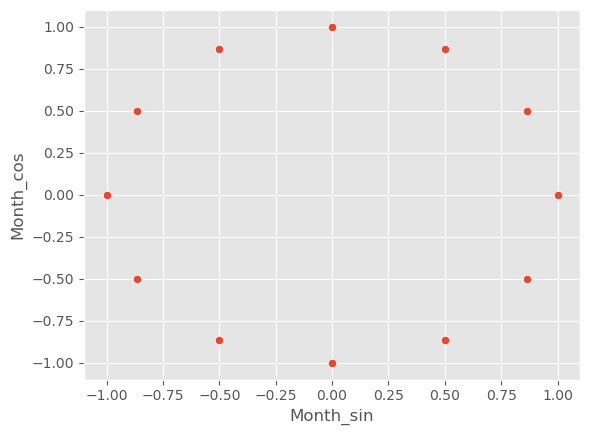

In [508]:
#codificación ciclicla de los meses
sns.scatterplot( x= "Month_sin", y= "Month_cos" , data = final_data_table.toPandas())

In [509]:
#registrar la tabla de fechas codificadas
sqlContext.sql("drop TABLE IF EXISTS final_data_table")
sqlContext.registerDataFrameAsTable(final_data_table, "final_data_table")

In [510]:
#seleccionar los datos a utilizar
preprocesing_data = sqlContext.sql("""
                    SELECT Tram_Horari,Sector_Economic,Month_sin,Month_cos,Day_sin,Day_cos,
                    dates_by_bd_hol_table.Business_Day, dates_by_bd_hol_table.Holiday,
                    Codi_Postal,Valor
                    FROM final_data_table
                    RIGHT JOIN dates_by_bd_hol_table ON dates_by_bd_hol_table.Date = final_data_table.Data
                """)
preprocesing_data.show(5)

+--------------------+---------------+-------------------+------------------+-------------------+------------------+------------+-------+-----------+-----+
|         Tram_Horari|Sector_Economic|          Month_sin|         Month_cos|            Day_sin|           Day_cos|Business_Day|Holiday|Codi_Postal|Valor|
+--------------------+---------------+-------------------+------------------+-------------------+------------------+------------+-------+-----------+-----+
|De 06:00:00 a 11:...|        Serveis|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|           1|      1|      08028|88076|
|De 06:00:00 a 11:...|    Residencial|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|           1|      1|      08041|38620|
|De 06:00:00 a 11:...|        Serveis|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|           1|      1|      08041|15346|
|De 12:00:00 a 17:...|        Serveis|0.49999999999999994|0.8660

In [511]:
sqlContext.sql("drop TABLE IF EXISTS preprocesing_data")
sqlContext.registerDataFrameAsTable(preprocesing_data, "preprocesing_data")

In [512]:
#utilizar las funciones (3) y (4) para utilizar el OneHotEncoder en las variables categoricas
codi_postal_indexer = string_indexer("Codi_Postal","CPIndex")
codi_postal_encoder = string_encoder("CPIndex","CPVec")

tram_horari_indexer = string_indexer("Tram_Horari","THIndex")
tram_horari_encoder = string_encoder("THIndex","THVec")

sector_economic_indexer = string_indexer("Sector_Economic","SEIndex")
sector_economic_encoder = string_encoder("SEIndex","SEVec")

In [513]:
#pipeline del OneHotEncoder
pipeline_OHE = Pipeline(stages=[
    codi_postal_indexer,
    tram_horari_indexer,
    sector_economic_indexer,
    codi_postal_encoder,
    tram_horari_encoder,
    sector_economic_encoder
])

In [514]:
#transformación de las características categoricas 
transmormed_table = pipeline_OHE.fit(preprocesing_data).transform(preprocesing_data)
transmormed_table.show(5)

+--------------------+---------------+-------------------+------------------+-------------------+------------------+------------+-------+-----------+-----+-------+-------+-------+---------------+-------------+-------------+
|         Tram_Horari|Sector_Economic|          Month_sin|         Month_cos|            Day_sin|           Day_cos|Business_Day|Holiday|Codi_Postal|Valor|CPIndex|THIndex|SEIndex|          CPVec|        THVec|        SEVec|
+--------------------+---------------+-------------------+------------------+-------------------+------------------+------------+-------+-----------+-----+-------+-------+-------+---------------+-------------+-------------+
|De 06:00:00 a 11:...|        Serveis|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|           1|      1|      08028|88076|    8.0|    1.0|    2.0| (41,[8],[1.0])|(3,[1],[1.0])|(3,[2],[1.0])|
|De 06:00:00 a 11:...|    Residencial|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.97814

In [515]:
#selección de características 
assembler = VectorAssembler(inputCols=[
 'Month_sin',
 'Month_cos',
 'Day_sin',
 'Day_cos',
 'Business_Day',
 'Holiday',   
 'CPVec',
 'THVec',
 'SEVec'
],outputCol='features')



In [516]:
transformed_df = assembler.transform(transmormed_table)
transformed_df = transformed_df.select(["features","Valor"])
transformed_df.show(5)

+--------------------+-----+
|            features|Valor|
+--------------------+-----+
|(53,[0,1,2,3,4,5,...|88076|
|(53,[0,1,2,3,4,5,...|38620|
|(53,[0,1,2,3,4,5,...|15346|
|(53,[0,1,2,3,4,5,...|25949|
|(53,[0,1,2,3,4,5,...|55770|
+--------------------+-----+
only showing top 5 rows



In [517]:
#train test split
seed = 17
train_data, test_data = transformed_df.randomSplit([0.8,.2],seed=seed)

# Random Forest

In [518]:
RF = RandomForestRegressor(featuresCol='features',labelCol='Valor')

In [519]:
fit_model_RF = RF.fit(train_data)

In [520]:
predictions_RF = fit_model_RF.transform(test_data)

In [521]:
rf_evaluator = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="rmse")

rmse_rf = rf_evaluator.evaluate(predictions_RF)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_rf)

r2_rf = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="r2")
r2_rf = r2_rf.evaluate(predictions_RF)
print("R-squared (R2) on test data = %g" % r2_rf) 

Root Mean Squared Error (RMSE) on test data = 18194.9


R-squared (R2) on test data = 0.668946


In [522]:
predictions_RF.select("Valor","prediction").orderBy("prediction").show()

+-----+-----------------+
|Valor|       prediction|
+-----+-----------------+
| 2967|5128.790744207016|
| 2926|5132.473235104425|
| 2721|5176.474315635588|
| 2747|5176.474315635588|
| 2626|5180.156806532997|
| 2894|5180.156806532997|
| 2203| 5215.23079436843|
| 2663| 5215.23079436843|
| 3223| 5215.23079436843|
| 2496|5218.913285265839|
| 2696|5262.914365797002|
| 2998|5262.914365797002|
| 2876|5262.914365797002|
| 2652|5262.914365797002|
| 2627|5262.914365797002|
| 2661|5262.914365797002|
| 2987|5262.914365797002|
| 2665|5262.914365797002|
| 2649|5262.914365797002|
| 2762| 5266.59685669441|
+-----+-----------------+
only showing top 20 rows



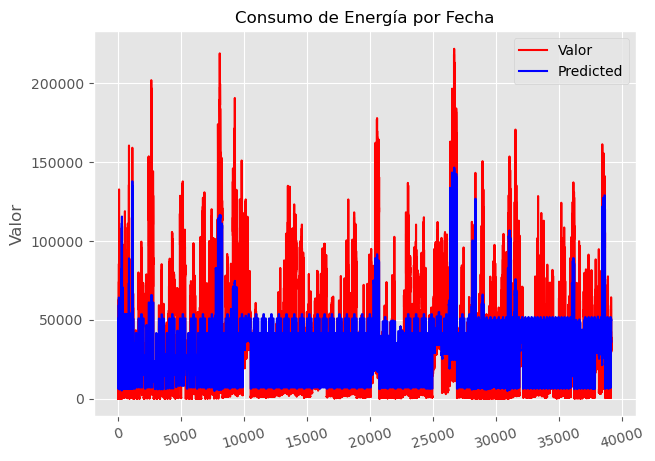

In [523]:
data_data_RF = predictions_RF.select("Valor","prediction").collect()

data_df_RF = pd.DataFrame(data_data_RF,columns=["Valor","prediction"])



fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.lineplot(data=data_df_RF, x=data_df_RF.index,y="Valor",color="r",label="Valor")
sns.lineplot(data=data_df_RF, x=data_df_RF.index,y="prediction",color="b",label="Predicted")
plt.xticks(rotation=15)
plt.legend()
plt.show()

# Linear Regression

In [524]:
lr = LinearRegression(featuresCol = 'features', labelCol='Valor', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-997.5573338565675,591.3241761162424,74.55921811013094,-786.4134877089397,5433.821319600623,-4184.427965515142,4284.761401932178,17229.044784213107,-6518.930914494564,6943.325270229887,16787.109238883266,3696.52540763112,11765.489600267227,10156.800865024943,36950.800956909596,-624.5607086671193,13366.881728658773,11677.522655502577,19206.452295218027,-11957.260424751048,-15397.498693331572,-12765.660891635069,-8854.140767459745,6271.659435745901,13892.523341168253,10091.669183500471,-3577.5648158602553,1659.7936018859139,10689.468652859276,-5777.894187277962,-6780.172508048434,-712.509196550848,12036.687594621853,-13921.512911408394,2637.7287760670492,37422.84113322113,-12684.714725567459,-10191.80069701913,-19799.673099889922,11458.226231434906,0.0,-207.39234591824962,-13453.94478966827,20620.642178161717,12838.169092835938,47118.633315076135,-7789.473245058195,-12412.223159167992,-1751.1488368046823,3182.7909324572465,13087.949106687583,39673.815034008054,59197.983748

In [525]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 18893.254074
r2: 0.640084


In [526]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction","Valor","features").show(5)

+-------------------+-----+--------------------+
|         prediction|Valor|            features|
+-------------------+-----+--------------------+
| -1740.472432980032|  120|(53,[0,1,2,3,4,5,...|
| -4485.340537536705|  142|(53,[0,1,2,3,4,5,...|
|-14152.695592148024|   96|(53,[0,1,2,3,4,5,...|
|-17839.984942397496|  105|(53,[0,1,2,3,4,5,...|
| -17480.52300584138|   91|(53,[0,1,2,3,4,5,...|
+-------------------+-----+--------------------+
only showing top 5 rows



In [527]:
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="Valor",metricName="r2")
r2_lr = lr_evaluator.evaluate(lr_predictions)

print("R Squared (R2) on test data = %g" % r2_lr )


R Squared (R2) on test data = 0.636385


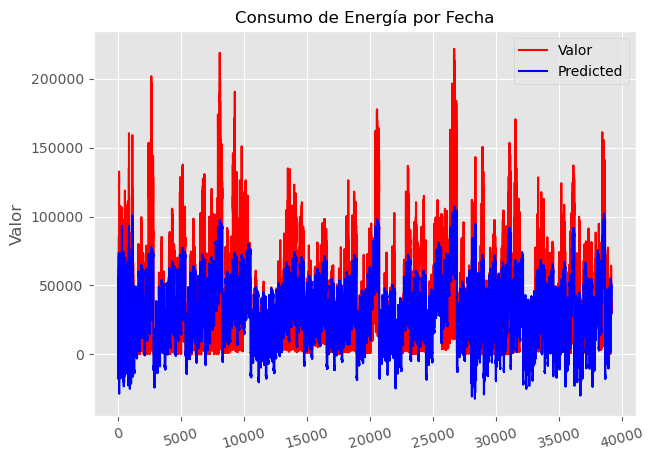

In [528]:
data_data_LR = lr_predictions.select("Valor","prediction").collect()

data_df_LR = pd.DataFrame(data_data_LR,columns=["Valor","prediction"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.lineplot(data=data_df_LR, x=data_df_LR.index,y="Valor",color="r",label="Valor")
sns.lineplot(data=data_df_LR, x=data_df_LR.index,y="prediction",color="b",label="Predicted")
plt.xticks(rotation=15)
plt.legend()
plt.show()

# Decision Tree

In [529]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Valor')
dt_model = dt.fit(train_data)

In [530]:
dt_predictions = dt_model.transform(test_data)
dt_evaluator = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="rmse")

In [531]:
rmse_dt = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_dt)


r2_dt = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="r2")
r2_dt = r2_dt.evaluate(dt_predictions)
print("R-squared (R2) on test data = %g" % r2_dt)

Root Mean Squared Error (RMSE) on test data = 17965.4


R-squared (R2) on test data = 0.677246


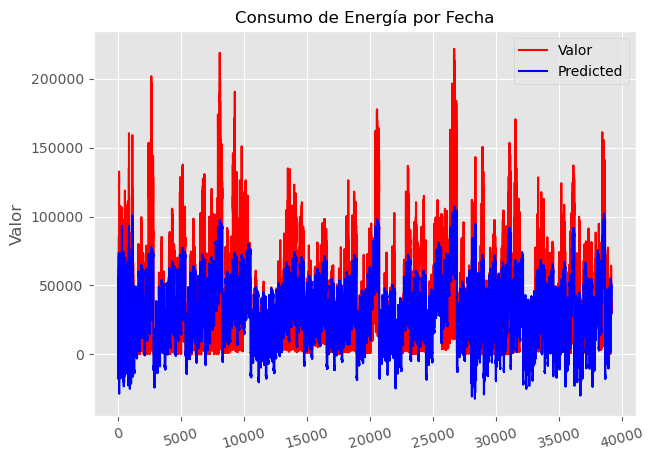

In [532]:
data_data_DT = dt_predictions.select("Valor","prediction").collect()

data_df_DT = pd.DataFrame(data_data_LR,columns=["Valor","prediction"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.lineplot(data=data_df_LR, x=data_df_DT.index,y="Valor",color="r",label="Valor")
sns.lineplot(data=data_df_LR, x=data_df_DT.index,y="prediction",color="b",label="Predicted")
plt.xticks(rotation=15)
plt.legend()
plt.show()

# Gradient-boosted tree regression


In [533]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'Valor',stepSize=.001)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'Valor', 'features').show()

+------------------+-----+--------------------+
|        prediction|Valor|            features|
+------------------+-----+--------------------+
| 4260.779707892225|  120|(53,[0,1,2,3,4,5,...|
| 4260.779707892225|  142|(53,[0,1,2,3,4,5,...|
| 4260.779707892225|   96|(53,[0,1,2,3,4,5,...|
| 4260.779707892225|  105|(53,[0,1,2,3,4,5,...|
| 4260.779707892225|   91|(53,[0,1,2,3,4,5,...|
| 4260.779707892225| 1613|(53,[0,1,2,3,4,5,...|
| 24141.33370362388|21910|(53,[0,1,2,3,4,5,...|
| 24141.33370362388|30121|(53,[0,1,2,3,4,5,...|
| 24141.33370362388|21751|(53,[0,1,2,3,4,5,...|
|34363.400177068615|43541|(53,[0,1,2,3,4,5,...|
|34363.400177068615|40041|(53,[0,1,2,3,4,5,...|
|34363.400177068615|35199|(53,[0,1,2,3,4,5,...|
|34363.400177068615|36293|(53,[0,1,2,3,4,5,...|
|34363.400177068615|29507|(53,[0,1,2,3,4,5,...|
|34363.400177068615|31044|(53,[0,1,2,3,4,5,...|
| 4260.779707892225|  134|(53,[0,1,2,3,4,5,...|
| 4260.779707892225|  149|(53,[0,1,2,3,4,5,...|
| 4260.779707892225|  317|(53,[0,1,2,3,4

In [534]:
gbt_evaluator = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="rmse")

rmse_gbt = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_gbt)

r2_gbt = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="r2")
r2_gbt = r2_gbt.evaluate(gbt_predictions)
print("R-squared (R2) on test data = %g" % r2_gbt)

Root Mean Squared Error (RMSE) on test data = 17817


R-squared (R2) on test data = 0.682558


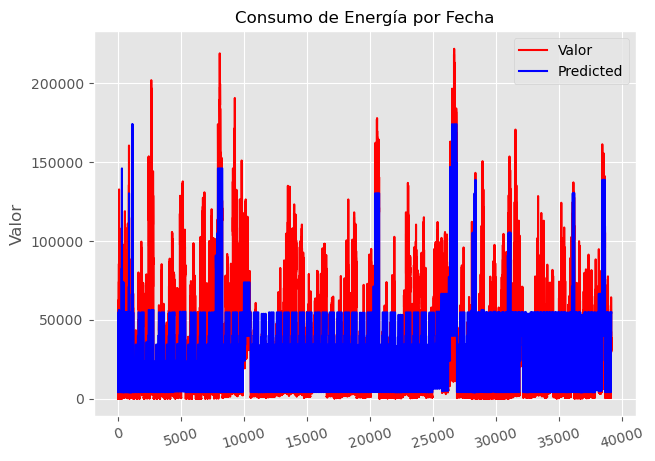

In [535]:
data_data_GBT = gbt_predictions.select("Valor","prediction").collect()

data_df_GBT = pd.DataFrame(data_data_GBT,columns=["Valor","prediction"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.lineplot(data=data_df_GBT, x=data_df_GBT.index,y="Valor",color="r",label="Valor")
sns.lineplot(data=data_df_GBT, x=data_df_GBT.index,y="prediction",color="b",label="Predicted")
plt.xticks(rotation=15)
plt.legend()
plt.show()

# Gradient-boosted tree regression Cross Validation

In [563]:
paramGrid = (ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [3, 7])\
  .addGrid(gbt.maxIter, [10, 20])\
  .build())

evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol=gbt.getLabelCol(), 
predictionCol=gbt.getPredictionCol())
evaluator_r2 = RegressionEvaluator(metricName="r2", labelCol=gbt.getLabelCol(), 
predictionCol=gbt.getPredictionCol())

cv = CrossValidator(estimator=gbt, 
                evaluator=evaluator_r2, 
                estimatorParamMaps=paramGrid, 
                numFolds=3)
#Predictions
fitModel = cv.fit(train_data)
predictions = fitModel.transform(test_data)
rmse = evaluator_rmse.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2) on test data = %g" % r2)

15083.310610510734


0.7724949257804896


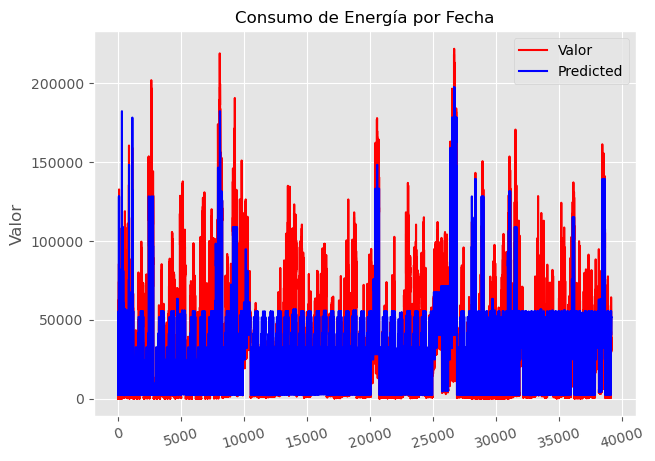

In [565]:
data_data_GBT_cv = predictions.select("Valor","prediction").collect()

data_df_GBT_cv = pd.DataFrame(data_data_GBT_cv,columns=["Valor","prediction"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.lineplot(data=data_df_GBT_cv, x=data_df_GBT_cv.index,y="Valor",color="r",label="Valor")
sns.lineplot(data=data_df_GBT_cv, x=data_df_GBT_cv.index,y="prediction",color="b",label="Predicted")
plt.xticks(rotation=15)
plt.legend()
plt.show()

## Creación del mejor modelo del GBT

In [581]:
#obtener los parametros del mejor modelo del crossvalidation
best_para ={param[0].name: param[1] for param in best_model_gbt.extractParamMap().items()}
best_para

{'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featureSubsetStrategy': 'all',
 'featuresCol': 'features',
 'impurity': 'variance',
 'labelCol': 'Valor',
 'leafCol': '',
 'lossType': 'squared',
 'maxBins': 32,
 'maxDepth': 7,
 'maxIter': 20,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'minWeightFractionPerNode': 0.0,
 'predictionCol': 'prediction',
 'seed': 4458598310842079779,
 'stepSize': 0.001,
 'subsamplingRate': 1.0,
 'validationTol': 0.01}

In [583]:
#generar el modelo con los mejores parámetros
gbt_cv = GBTRegressor(cacheNodeIds= False,
 checkpointInterval= 10,
 featureSubsetStrategy= 'all',
 featuresCol = 'features',
 impurity = 'variance',
 labelCol = 'Valor',
 lossType= 'squared',
 maxBins= 32,
 maxDepth= 7,
 maxIter= 20,
 maxMemoryInMB= 256,
 minInfoGain= 0.0,
 minInstancesPerNode= 1,
 minWeightFractionPerNode= 0.0,
 predictionCol= 'prediction',
 seed= 4458598310842079779,
 stepSize= 0.001,
 subsamplingRate= 1.0,
 validationTol= 0.01)

gbt_model_cv = gbt_cv.fit(train_data)
gbt_predictions_cv = gbt_model_cv.transform(test_data)
gbt_predictions_cv.select('prediction', 'Valor', 'features').show()

+------------------+-----+--------------------+
|        prediction|Valor|            features|
+------------------+-----+--------------------+
|2451.2767285258738|  120|(53,[0,1,2,3,4,5,...|
|2451.2767285258738|  142|(53,[0,1,2,3,4,5,...|
|2451.2767285258738|   96|(53,[0,1,2,3,4,5,...|
|2451.2767285258738|  105|(53,[0,1,2,3,4,5,...|
|2451.2767285258738|   91|(53,[0,1,2,3,4,5,...|
|2451.2767285258738| 1613|(53,[0,1,2,3,4,5,...|
|24900.803504773703|21910|(53,[0,1,2,3,4,5,...|
|24900.803504773703|30121|(53,[0,1,2,3,4,5,...|
|24900.803504773703|21751|(53,[0,1,2,3,4,5,...|
|32693.492690157567|43541|(53,[0,1,2,3,4,5,...|
|32693.492690157567|40041|(53,[0,1,2,3,4,5,...|
|32693.492690157567|35199|(53,[0,1,2,3,4,5,...|
|32693.492690157567|36293|(53,[0,1,2,3,4,5,...|
|32693.492690157567|29507|(53,[0,1,2,3,4,5,...|
|32693.492690157567|31044|(53,[0,1,2,3,4,5,...|
|2451.2767285258738|  134|(53,[0,1,2,3,4,5,...|
|2451.2767285258738|  149|(53,[0,1,2,3,4,5,...|
|2451.2767285258738|  317|(53,[0,1,2,3,4

In [585]:
gbt_evaluator_cv = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="rmse")

rmse_gbt_cv = gbt_evaluator.evaluate(gbt_predictions_cv)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_gbt_cv)

r2_gbt_cv = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="r2")
r2_gbt_cv = r2_gbt_cv.evaluate(gbt_predictions_cv)
print("R-squared (R2) on test data = %g" % r2_gbt_cv)

Root Mean Squared Error (RMSE) on test data = 15083.3


R-squared (R2) on test data = 0.772495


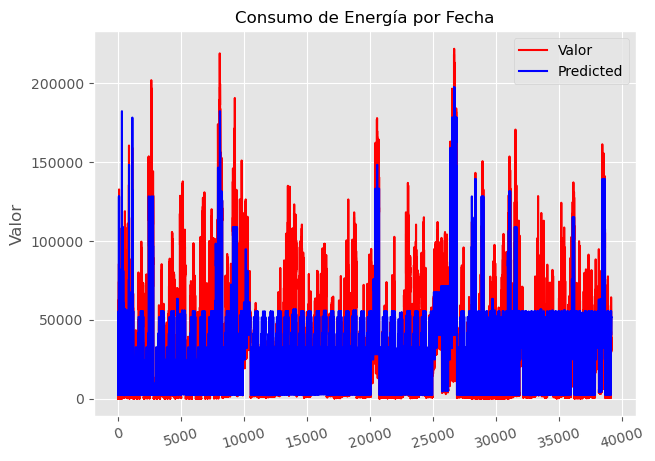

In [586]:
data_data_GBT_best_model = gbt_predictions_cv.select("Valor","prediction").collect()

data_df_GBT_best_model = pd.DataFrame(data_data_GBT_best_model,columns=["Valor","prediction"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.lineplot(data=data_df_GBT_best_model, x=data_df_GBT_best_model.index,y="Valor",color="r",label="Valor")
sns.lineplot(data=data_df_GBT_best_model, x=data_df_GBT_best_model.index,y="prediction",color="b",label="Predicted")
plt.xticks(rotation=15)
plt.legend()
plt.show()

# Comparación de resultados

In [587]:
resultados = { "r2":[r2_rf,r2_lr,r2_dt,r2_gbt,r2_gbt_cv],
              "rmse":[rmse_rf,trainingSummary.rootMeanSquaredError,rmse_dt,rmse_gbt,rmse_gbt_cv]
    }

resultados_df = pd.DataFrame.from_dict(resultados, orient='columns')
resultados_df.index = ["RF","LR","DT","GBT","GBT_CV"]
resultados_df

,r2,rmse
RF,0.668946,18194.942280
LR,0.636385,18893.254074
DT,0.677246,17965.403459
GBT,0.682558,17816.957922
GBT_CV,0.772495,15083.310611


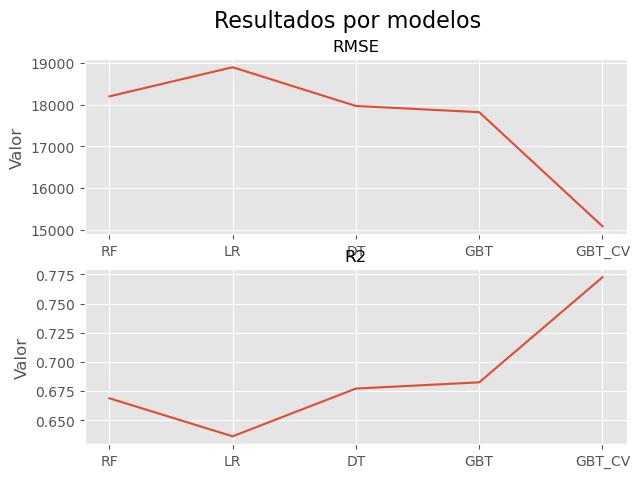

In [588]:
fig,axes = plt.subplots(2,1,figsize=(7,5))
sns.lineplot(data=resultados_df,x=resultados_df.index,y="r2",ax=axes[1])
sns.lineplot(data=resultados_df,x=resultados_df.index,y="rmse",ax=axes[0])
fig.suptitle("Resultados por modelos",fontsize=16)
axes[0].set_title("RMSE",fontsize=12)
axes[0].set_ylabel('Valor')
axes[1].set_title("R2",fontsize=12)
axes[1].set_ylabel('Valor')
plt.show() 


La gráfica anterior muestra que el modelo Gradient-boosted tree obtenido con parámetros del crossvalidation es el que tiene un menor RMSE y un mayor R2, por lo que el modelo se ajusta mejor para la prediccón del consumo de energía.

# TEST

Utilizaremos datos del 2022 para realizar un test en el modelo propuesto para ver su predicción.

In [538]:
url_test = "https://opendata-ajuntament.barcelona.cat/data/dataset/\
d9479057-781f-42b4-85e6-721bd0284130/resource/e685fa1a-9fbe-41a4-98a0-173464cd0c5f/\
download/2022_consum_electricitat_bcn.csv"

file_name_test, headers_test = urllib.request.urlretrieve(url_test)



In [539]:
#se vuelven a cargar los datos
energy_consumption_test = sqlContext.read.format("csv").options(delimiter=',',header='True')\
                  .schema(schema = customSchema).load(file_name_test)
energy_consumption_test.show()

+----+----------+-----------+---------------+--------------------+-----+
| Any|      Data|Codi_Postal|Sector_Economic|         Tram_Horari|Valor|
+----+----------+-----------+---------------+--------------------+-----+
|2022|2022-01-01|      08001|      Indústria|De 00:00:00 a 05:...|  817|
|2022|2022-01-01|      08001|      Indústria|De 06:00:00 a 11:...|  942|
|2022|2022-01-01|      08001|      Indústria|De 12:00:00 a 17:...| 1145|
|2022|2022-01-01|      08001|      Indústria|De 18:00:00 a 23:...| 1184|
|2022|2022-01-01|      08001|      Indústria|           No consta|    0|
|2022|2022-01-01|      08001|    Residencial|De 00:00:00 a 05:...|24464|
|2022|2022-01-01|      08001|    Residencial|De 06:00:00 a 11:...|24860|
|2022|2022-01-01|      08001|    Residencial|De 12:00:00 a 17:...|36160|
|2022|2022-01-01|      08001|    Residencial|De 18:00:00 a 23:...|38349|
|2022|2022-01-01|      08001|    Residencial|           No consta|    0|
|2022|2022-01-01|      08001|        Serveis|De 00:

In [540]:
#registrar la tabla
sqlContext.sql("drop TABLE IF EXISTS energy_consumption_test")
sqlContext.registerDataFrameAsTable(energy_consumption_test, "energy_consumption_test")

In [541]:
final_data_table_test = sqlContext.sql(""" SELECT Data, MONTH(Data) AS Month,DAY(Data) AS Day,Codi_Postal,
                   Tram_Horari,Sector_Economic, SUM(Valor) as Valor
                   FROM energy_consumption_test 
                   WHERE Tram_Horari != "No consta" AND Data >= '2022-01-01' AND Data < '2022-04-30'
                   Group By Data,Codi_Postal,Tram_Horari,Sector_Economic
                   ORDER BY Data
                      """)
final_data_table_test.show()

+----------+-----+---+-----------+--------------------+---------------+-----+
|      Data|Month|Day|Codi_Postal|         Tram_Horari|Sector_Economic|Valor|
+----------+-----+---+-----------+--------------------+---------------+-----+
|2022-01-01|    1|  1|      08038|De 00:00:00 a 05:...|    Residencial|25407|
|2022-01-01|    1|  1|      08016|De 00:00:00 a 05:...|      Indústria|  793|
|2022-01-01|    1|  1|      08002|De 18:00:00 a 23:...|    Residencial|27642|
|2022-01-01|    1|  1|      08029|De 12:00:00 a 17:...| No especificat|   45|
|2022-01-01|    1|  1|      08011|De 00:00:00 a 05:...|        Serveis|17158|
|2022-01-01|    1|  1|      08008|De 06:00:00 a 11:...|        Serveis|22289|
|2022-01-01|    1|  1|      08011|De 12:00:00 a 17:...|        Serveis|22641|
|2022-01-01|    1|  1|      08008|De 18:00:00 a 23:...| No especificat|  461|
|2022-01-01|    1|  1|      08035|De 00:00:00 a 05:...|    Residencial|18281|
|2022-01-01|    1|  1|      08042|De 00:00:00 a 05:...|      Ind

In [542]:
dates_test = pd.date_range(start='2022/01/01', end='2022/03/31')
dates_test_df = pd.DataFrame(dates_test,columns=["Date"])
dates_test_df

,Date
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05
...,...
85,2022-03-27
86,2022-03-28
87,2022-03-29
88,2022-03-30


In [543]:
bday_test = dates_test_df.Date.apply(type_day)
bday_test.rename("Business_Day",inplace=True)

0     0
1     0
2     1
3     1
4     1
     ..
85    0
86    1
87    1
88    1
89    1
Name: Business_Day, Length: 90, dtype: int64

In [544]:
holiday_test = dates_test_df.Date.apply(cat_hol) 
holiday_test.rename("Holiday",inplace=True)

0     1
1     0
2     0
3     0
4     0
     ..
85    0
86    0
87    0
88    0
89    0
Name: Holiday, Length: 90, dtype: int64

In [545]:
dates_by_bd_hol_test = pd.concat([dates_test_df,bday_test,holiday_test],axis=1)
dates_by_bd_hol_test

,Date,Business_Day,Holiday
0,2022-01-01,0,1
1,2022-01-02,0,0
2,2022-01-03,1,0
3,2022-01-04,1,0
4,2022-01-05,1,0
...,...,...,...
85,2022-03-27,0,0
86,2022-03-28,1,0
87,2022-03-29,1,0
88,2022-03-30,1,0


In [546]:
#guardar el DF en un csv
dates_by_bd_hol_test.to_csv("dates_by_bd_hol_test.csv",index=False) 

In [547]:
#cargar el archivo csv en pyspark
dates_by_bd_hol_table_test = sqlContext.read.format("csv").options(delimiter=',',header='True',
                                                           inferschema='True').load("dates_by_bd_hol_test.csv")

In [548]:
#registrar la tabla de fechas
sqlContext.sql("drop TABLE IF EXISTS dates_by_bd_hol_table_test")
sqlContext.registerDataFrameAsTable(dates_by_bd_hol_table_test, "dates_by_bd_hol_table_test")

In [549]:
final_data_table_test = final_data_table_test.withColumn('Month_sin',sin(2 * math.pi * final_data_table_test['Month']/12))
final_data_table_test = final_data_table_test.withColumn('Month_cos',cos(2 * math.pi * final_data_table_test['Month']/12))

final_data_table_test = final_data_table_test.withColumn('Day_sin',sin(2 * math.pi * final_data_table_test['Day']/30))
final_data_table_test = final_data_table_test.withColumn('Day_cos',cos(2 * math.pi * final_data_table_test['Day']/30))

In [550]:
final_data_table_test.show(5)

+----------+-----+---+-----------+--------------------+---------------+-----+-------------------+------------------+-------------------+------------------+
|      Data|Month|Day|Codi_Postal|         Tram_Horari|Sector_Economic|Valor|          Month_sin|         Month_cos|            Day_sin|           Day_cos|
+----------+-----+---+-----------+--------------------+---------------+-----+-------------------+------------------+-------------------+------------------+
|2022-01-01|    1|  1|      08037|De 06:00:00 a 11:...|      Indústria|  913|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|
|2022-01-01|    1|  1|      08017|De 12:00:00 a 17:...|      Indústria| 1135|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|
|2022-01-01|    1|  1|      08042|De 00:00:00 a 05:...|      Indústria|  637|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|
|2022-01-01|    1|  1|      08008|De 06:00:00 a 11:...|        S

In [551]:
#registrar la tabla de fechas codificadas
sqlContext.sql("drop TABLE IF EXISTS final_data_table_test")
sqlContext.registerDataFrameAsTable(final_data_table_test, "final_data_table_test")

In [552]:
#seleccionar los datos a utilizar
preprocesing_data_test = sqlContext.sql("""
                    SELECT Tram_Horari,Sector_Economic,Month_sin,Month_cos,Day_sin,Day_cos,
                    dates_by_bd_hol_table_test.Business_Day, dates_by_bd_hol_table_test.Holiday,
                    Codi_Postal,Valor
                    FROM final_data_table_test
                    RIGHT JOIN dates_by_bd_hol_table_test 
                    ON dates_by_bd_hol_table_test.Date = final_data_table_test.Data
                    WHERE Codi_Postal IS NOT NULL
                    ORDER BY Data
                """)

In [553]:
final_data_table_test.show(5)

+----------+-----+---+-----------+--------------------+---------------+-----+-------------------+------------------+-------------------+------------------+
|      Data|Month|Day|Codi_Postal|         Tram_Horari|Sector_Economic|Valor|          Month_sin|         Month_cos|            Day_sin|           Day_cos|
+----------+-----+---+-----------+--------------------+---------------+-----+-------------------+------------------+-------------------+------------------+
|2022-01-01|    1|  1|      08037|De 06:00:00 a 11:...|      Indústria|  913|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|
|2022-01-01|    1|  1|      08017|De 12:00:00 a 17:...|      Indústria| 1135|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|
|2022-01-01|    1|  1|      08042|De 00:00:00 a 05:...|      Indústria|  637|0.49999999999999994|0.8660254037844387|0.20791169081775931|0.9781476007338057|
|2022-01-01|    1|  1|      08008|De 06:00:00 a 11:...|        S

In [554]:
sqlContext.sql("drop TABLE IF EXISTS preprocesing_data_test")
sqlContext.registerDataFrameAsTable(preprocesing_data_test, "preprocesing_data_test")

In [555]:
transmormed_table_test = pipeline_OHE.fit(preprocesing_data_test).transform(preprocesing_data_test)

In [556]:
transformed_test_df = assembler.transform(transmormed_table_test)
transformed_test_df = transformed_test_df.select(["features","Valor"])
transformed_test_df.show(5)

+--------------------+-----+
|            features|Valor|
+--------------------+-----+
|(53,[0,1,2,3,5,6,...|  225|
|(53,[0,1,2,3,5,9,...|22289|
|(53,[0,1,2,3,5,9]...|  461|
|(53,[0,1,2,3,5,42...|  913|
|(53,[0,1,2,3,5,47...|  637|
+--------------------+-----+
only showing top 5 rows



In [589]:
gbt_predictions_test = gbt_model_cv.transform(transformed_test_df)
gbt_predictions_test.select('prediction', 'Valor', 'features').show()

+------------------+-----+--------------------+
|        prediction|Valor|            features|
+------------------+-----+--------------------+
|2451.2767285258738|  225|(53,[0,1,2,3,5,6,...|
| 51834.92443830906|22289|(53,[0,1,2,3,5,9,...|
|2451.2767285258738|  461|(53,[0,1,2,3,5,9]...|
| 2425.325409623948|  913|(53,[0,1,2,3,5,42...|
|2451.2767285258738|  637|(53,[0,1,2,3,5,47...|
| 2720.479393805492| 1135|(53,[0,1,2,3,5,10...|
| 51834.92443830906|30268|(53,[0,1,2,3,5,34...|
|48368.359110028825| 2753|(53,[0,1,2,3,5,18...|
|2451.2767285258738|  121|(53,[0,1,2,3,5,7]...|
| 79387.76478179071|78463|(53,[0,1,2,3,5,14...|
| 64672.29820425059|65432|(53,[0,1,2,3,5,35...|
|2451.2767285258738|  458|(53,[0,1,2,3,5,46...|
|  55579.7059744009|42844|(53,[0,1,2,3,5,19...|
| 51834.92443830906|13324|(53,[0,1,2,3,5,37...|
|24900.803504773703| 9529|(53,[0,1,2,3,5,9,...|
| 51834.92443830906|77618|(53,[0,1,2,3,5,11...|
|2451.2767285258738| 1380|(53,[0,1,2,3,5,15...|
|2451.2767285258738|   45|(53,[0,1,2,3,5

In [590]:
gbt_evaluator_test = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="rmse")

rmse_gbt_test = gbt_evaluator_test.evaluate(gbt_predictions_test)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse_gbt_test)

r2_gbt_test = RegressionEvaluator(labelCol="Valor", predictionCol="prediction", metricName="r2")
r2_gbt_test = r2_gbt_test.evaluate(gbt_predictions_test)
print("R-squared (R2) on test data = %g" % r2_gbt_test)

Root Mean Squared Error (RMSE) on test data = 18142.1


R-squared (R2) on test data = 0.677877


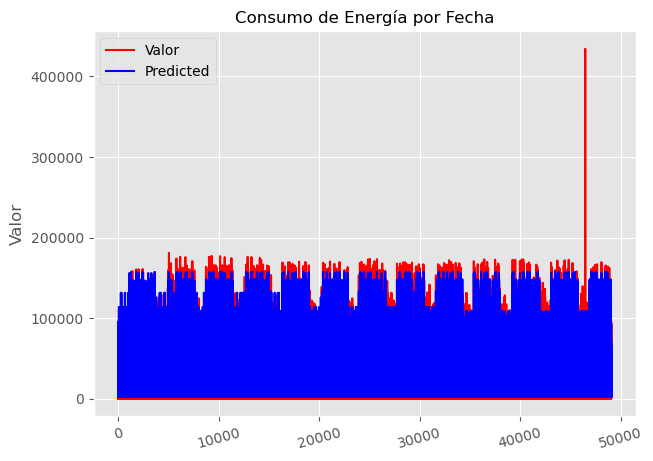

In [591]:
data_data_GBT_test = gbt_predictions_test.select("Valor","prediction").collect()

data_df_GBT_test = pd.DataFrame(data_data_GBT_test,columns=["Valor","prediction"])

fig = plt.figure(figsize=(7,5))
plt.title("Consumo de Energía por Fecha",fontsize=12)
sns.lineplot(data=data_df_GBT_test, x=data_df_GBT_test.index,y="Valor",color="r",label="Valor")
sns.lineplot(data=data_df_GBT_test, x=data_df_GBT_test.index,y="prediction",color="b",label="Predicted")
plt.xticks(rotation=15)
plt.legend()
plt.show()

**Conclusión**
Existe una disminución en el ajuste del modelo pero en general el modelo tiene una buena predicción, puede que haga falta algúna variable para poder ajustar el modelo. El método de crossvalidation tiene un gran gasto computacional, eso sí, todo el procedimiento se realizo en local faltando realizar todo en un servicio como google colab.

In [592]:
sc.stop()

23/03/21 21:04:57 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 5106156 ms exceeds timeout 120000 ms
23/03/21 21:04:58 WARN SparkContext: Killing executors is not supported by current scheduler.
